<a href="https://colab.research.google.com/github/finlytics-hub/LTV_predictions/blob/master/LTV_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In [ ]:
# import and install all required libraries
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

! pip install lifetimes==0.11.3
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

In [2]:
# Load data
data = pd.read_csv('.../OnlineRetail_2yrs.csv')

# EDA and Data Preprocessing

In [3]:
data.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,1/12/2009 7:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12.0,1/12/2009 7:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,1/12/2009 7:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,1/12/2009 7:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,1/12/2009 7:45,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24.0,1/12/2009 7:45,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24.0,1/12/2009 7:45,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10.0,1/12/2009 7:45,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12.0,1/12/2009 7:46,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12.0,1/12/2009 7:46,3.75,13085.0,United Kingdom


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981331 entries, 0 to 981330
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      981330 non-null  object 
 1   StockCode    981330 non-null  object 
 2   Description  976948 non-null  object 
 3   Quantity     981330 non-null  float64
 4   InvoiceDate  981330 non-null  object 
 5   Price        981330 non-null  float64
 6   Customer ID  741301 non-null  float64
 7   Country      981330 non-null  object 
dtypes: float64(3), object(5)
memory usage: 59.9+ MB


In [5]:
# Convert InvoiceDate into DateTime format and extract the date values
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate']).dt.date
# drop rows with missing CustomerID as our analysis will be at the individual customer level
data.dropna(axis = 0, subset = ['Customer ID'], inplace = True)
# filter out the negative values from Quantity field as these could relate to returns that are not relevant to LTV predictions
data = data[(data['Quantity'] > 0)]
# create a new column for Sales per invoice and filter out only the required columns for the Lifetimes package
data['Sales'] = data['Quantity'] * data['Price']
data_final = data[['Customer ID', 'InvoiceDate', 'Sales']]
data_final.head()

,Customer ID,InvoiceDate,Sales
0,13085.0,2009-01-12,83.4
1,13085.0,2009-01-12,81.0
2,13085.0,2009-01-12,81.0
3,13085.0,2009-01-12,100.8
4,13085.0,2009-01-12,30.0


In [6]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 725296 entries, 0 to 981330
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Customer ID  725296 non-null  float64
 1   InvoiceDate  725296 non-null  object 
 2   Sales        725296 non-null  float64
dtypes: float64(2), object(1)
memory usage: 22.1+ MB


In [7]:
# transform our transaction level data into the required summary form for Lifetimes
data_summary = summary_data_from_transaction_data(data_final, customer_id_col = 'Customer ID', datetime_col = 'InvoiceDate', monetary_value_col = 'Sales', freq = 'D')
# used freq = 'D' since we have a daily transactions log
data_summary.head(10)

,frequency,recency,T,monetary_value
Customer ID,,,,
12346.0,7.0,400.0,726.0,11066.637143
12608.0,0.0,0.0,405.0,0.000000
12745.0,1.0,147.0,575.0,266.930000
12746.0,0.0,0.0,541.0,0.000000
12747.0,25.0,858.0,881.0,355.835600
12748.0,202.0,967.0,972.0,279.101436
12749.0,6.0,555.0,578.0,1020.433333
12777.0,0.0,0.0,488.0,0.000000
12819.0,0.0,0.0,519.0,0.000000


In [8]:
# retain only those customers with frequency > 0
data_summary = data_summary[data_summary['frequency'] > 0]

In [9]:
# Some descriptive statistics of the summary data
data_summary.describe()

,frequency,recency,T,monetary_value
count,3820.000000,3820.000000,3820.000000,3820.000000
mean,6.490052,434.977225,582.336126,426.423990
std,10.721823,260.047471,231.164939,2775.554294
min,1.000000,1.000000,10.000000,3.900000
25%,2.000000,218.000000,427.750000,190.233036
50%,3.000000,424.000000,619.000000,301.855000
75%,7.000000,623.000000,701.000000,440.570500
max,202.000000,1062.000000,1062.000000,168469.600000


# BG/NBD Model Training & Visualisation

In [10]:
# fit the BG/NBD model to our data_summary
bgf = BetaGeoFitter()
bgf.fit(data_summary['frequency'], data_summary['recency'], data_summary['T'])

<lifetimes.BetaGeoFitter: fitted with 3820 subjects, a: 0.08, alpha: 142.04, b: 0.90, r: 1.72>

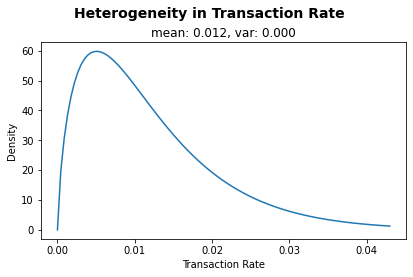

In [11]:
# plot the estimated gamma distribution of λ (customers' propensities to purchase)
plot_transaction_rate_heterogeneity(bgf);

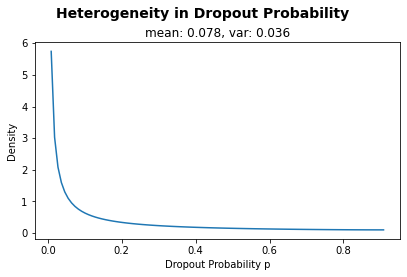

In [12]:
# plot the estimated beta distribution of p, a customers' probability of dropping out immediately after a transaction
plot_dropout_rate_heterogeneity(bgf);

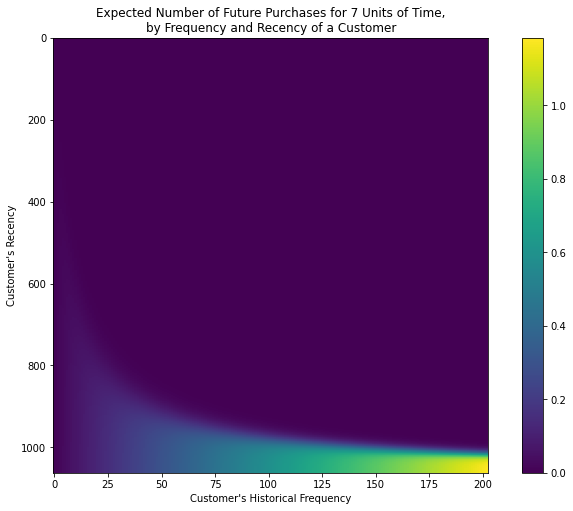

In [13]:
# visualize our frequency/recency matrix
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf, T = 7);

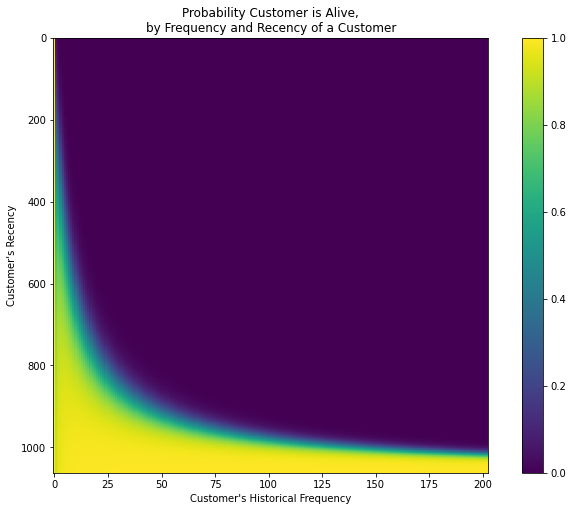

In [14]:
# Now let's visualise the probability of a customer being alive
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf);

# Model Validation

In [15]:
# partition the dataset into a calibration and a holdout dataset
summary_cal_holdout = calibration_and_holdout_data(data_final, 'Customer ID', 'InvoiceDate', freq = "D", monetary_value_col = 'Sales', calibration_period_end='2011-06-30')
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
Customer ID,,,,,,,
12346.0,7.0,400.0,563.0,11066.637143,0.0,0.0000,163.0
12608.0,0.0,0.0,242.0,0.000000,0.0,0.0000,163.0
12745.0,1.0,147.0,412.0,266.930000,0.0,0.0000,163.0
12746.0,0.0,0.0,378.0,0.000000,0.0,0.0000,163.0
12747.0,22.0,716.0,718.0,356.498182,3.0,42.1172,163.0


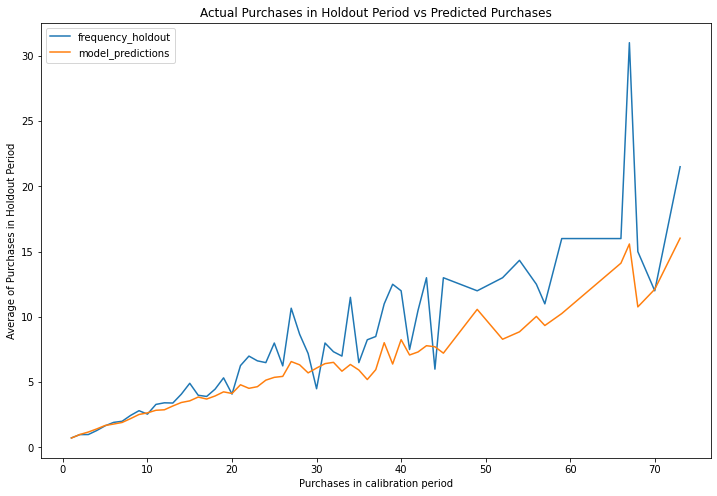

In [16]:
# again, retain only the +ve frequency_cal values
summary_cal_holdout = summary_cal_holdout[summary_cal_holdout['frequency_cal'] > 0]
# compare the predicted # of repeat puchases with actual repeat purchases during the holdout period
bgf_cal = BetaGeoFitter()
bgf_cal.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf_cal, summary_cal_holdout, kind = 'frequency_cal', n = int(summary_cal_holdout['frequency_holdout'].max()), figsize = (12,8));

# Gamma-Gamma Model Fitting

In [17]:
# Let's fit the Gamma-Gamma model to our data_summary
ggf = GammaGammaFitter()
ggf.fit(frequency = data_summary['frequency'], monetary_value = data_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 3820 subjects, p: 2.21, q: 3.91, v: 508.58>

# Prediction Time!

In [18]:
# Calculate the expected number of repeat purchases up to time t for a randomly chosen individual from the population
t = 30 # to calculate the number of expected repeat purchases over the next 30 days
data_summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data_summary['frequency'], data_summary['recency'], data_summary['T'])
data_summary.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
Customer ID,,,,,
12971.0,98.0,716.0,725.0,162.360612,3.438204
14606.0,180.0,998.0,1003.0,170.255889,4.751843
15311.0,195.0,1062.0,1062.0,594.605846,4.894931
17841.0,192.0,1031.0,1031.0,366.423490,4.947514
12748.0,202.0,967.0,972.0,279.101436,5.475191


In [19]:
# Calculate probability of being currently alive and assign to each CustomerID
data_summary['p_alive'] = bgf.conditional_probability_alive(data_summary['frequency'], data_summary['recency'], data_summary['T'])
data_summary.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases,p_alive
Customer ID,,,,,,
12971.0,98.0,716.0,725.0,162.360612,3.438204,0.997802
14606.0,180.0,998.0,1003.0,170.255889,4.751843,0.999063
15311.0,195.0,1062.0,1062.0,594.605846,4.894931,0.999609
17841.0,192.0,1031.0,1031.0,366.423490,4.947514,0.999603
12748.0,202.0,967.0,972.0,279.101436,5.475191,0.999057


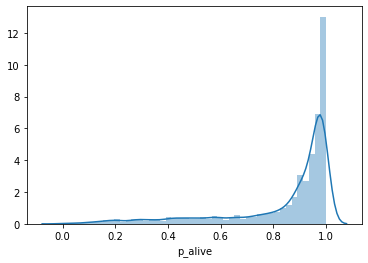

In [20]:
sns.distplot(data_summary['p_alive']);

In [21]:
data_summary['churn'] = ['churned' if p_alive < 0.5 else 'not churned' for p_alive in data_summary['p_alive']]
data_summary['churn'][(data_summary['p_alive'] >= 0.5) & (data_summary['p_alive'] < 0.75)] = "high risk"
data_summary['churn'].value_counts()

not churned    3012
churned         418
high risk       390
Name: churn, dtype: int64

In [24]:
# After applying Gamma-Gamma model, now we can estimate average transaction value for each customer over his/her lifetime
data_summary['predicted_Sales'] = ggf.conditional_expected_average_profit(data_summary['frequency'], data_summary['monetary_value'])
data_summary.head()

,frequency,recency,T,monetary_value,predicted_purchases,p_alive,churn,predicted_Sales
Customer ID,,,,,,,,
12346.0,7.0,400.0,726.0,11066.637143,0.180163,0.598812,high risk,9378.319099
12745.0,1.0,147.0,575.0,266.930000,0.056790,0.500635,high risk,335.079712
12747.0,25.0,858.0,881.0,355.835600,0.778232,0.994413,not churned,357.388678
12748.0,202.0,967.0,972.0,279.101436,5.475191,0.999057,not churned,279.798520
12749.0,6.0,555.0,578.0,1020.433333,0.315755,0.983687,not churned,906.592768


In [25]:
# Final piece of the puzzle - calculate LTV for each customer over the next 12 months with an assumed monthly discount rate of 0.01%
data_summary['LTV'] = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    data_summary['frequency'], data_summary['recency'], data_summary['T'], data_summary['monetary_value'],
    time = 12, # number of months to predict LTV for
    discount_rate = 0.01 # monthly discount rate ~ 12.7% annually
)
data_summary.head()

,frequency,recency,T,monetary_value,predicted_purchases,p_alive,churn,predicted_Sales,LTV
Customer ID,,,,,,,,,
12346.0,7.0,400.0,726.0,11066.637143,0.180163,0.598812,high risk,9378.319099,18738.461340
12745.0,1.0,147.0,575.0,266.930000,0.056790,0.500635,high risk,335.079712,208.808918
12747.0,25.0,858.0,881.0,355.835600,0.778232,0.994413,not churned,357.388678,3095.060099
12748.0,202.0,967.0,972.0,279.101436,5.475191,0.999057,not churned,279.798520,17070.707489
12749.0,6.0,555.0,578.0,1020.433333,0.315755,0.983687,not churned,906.592768,3165.452100


In [26]:
# Let's identify our top 20 customers based on LTV
best_projected_cust_LTV = data_summary.sort_values('LTV').tail(20)
best_projected_cust_LTV

,frequency,recency,T,monetary_value,predicted_purchases,p_alive,churn,predicted_Sales,LTV
Customer ID,,,,,,,,,
15749.0,1.0,197.0,236.0,22998.400000,0.192763,0.898172,not churned,10156.861949,21151.652445
16422.0,91.0,680.0,698.0,694.664725,3.286202,0.993793,not churned,690.283106,25202.276486
12931.0,42.0,1040.0,1062.0,2171.127143,1.083837,0.995944,not churned,2116.984880,25578.027733
13798.0,98.0,849.0,850.0,768.906837,3.009507,0.999140,not churned,763.851478,25585.680940
15838.0,28.0,713.0,725.0,2631.000000,1.022660,0.995885,not churned,2530.380718,28747.172575
14088.0,13.0,411.0,422.0,3949.358462,0.775024,0.992170,not churned,3622.244698,30977.979773
15769.0,39.0,717.0,758.0,2223.700513,1.337981,0.987092,not churned,2163.815167,32181.504367
15311.0,195.0,1062.0,1062.0,594.605846,4.894931,0.999609,not churned,593.215374,32378.690579
14298.0,44.0,705.0,758.0,2023.197500,1.480717,0.972922,not churned,1975.735726,32520.654941
